**FB PROPHET **

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import files

In [2]:
uploaded = files.upload()

Saving INFY.NS.csv to INFY.NS.csv


In [3]:
df = pd.read_csv("/content/INFY.NS.csv")

In [4]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1996-01-01,0.794921,0.796679,0.791015,0.796679,0.549483,204800.0
1,1996-01-02,0.794921,0.798828,0.793457,0.793457,0.547260,204800.0
2,1996-01-03,0.798828,0.798828,0.798828,0.798828,0.550965,102400.0
3,1996-01-04,0.791015,0.794921,0.791015,0.793554,0.547327,307200.0
4,1996-01-05,0.784179,0.784179,0.784179,0.784179,0.540861,51200.0


In [5]:
!pip install prophet --quiet
from prophet import Prophet

In [43]:
df_copy = df.copy()

In [44]:
df_prophet = df_copy[['Date', 'Close']].copy()

In [45]:
df_prophet.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

In [47]:
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

In [48]:
print(df_prophet.head())
print(df_prophet.dtypes)

          ds         y
0 1996-01-01  0.796679
1 1996-01-02  0.793457
2 1996-01-03  0.798828
3 1996-01-04  0.793554
4 1996-01-05  0.784179
ds    datetime64[ns]
y            float64
dtype: object


# Sort and clean data

In [49]:
df = df.sort_values('Date')

In [50]:
df = df.drop_duplicates(subset='Date').dropna(subset=['Close'])

In [51]:
df = df.replace([np.inf, -np.inf], np.nan).dropna()

**Log transform for stability**

In [91]:
df['Close_log'] = np.log(df['Close'])
df_prophet = df[['Date', 'Close_log']].copy()
df_prophet.rename(columns={'Date': 'ds', 'Close_log': 'y'}, inplace=True)

In [92]:
df_prophet['floor'] = 0
df_prophet['cap'] = df_prophet['y'].max() * 1.5

In [93]:
model = Prophet(growth='logistic', daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True)

model fiting

In [94]:
model.fit(df_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp1rnjs06s/uplszomt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1rnjs06s/4zeheunn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87610', 'data', 'file=/tmp/tmp1rnjs06s/uplszomt.json', 'init=/tmp/tmp1rnjs06s/4zeheunn.json', 'output', 'file=/tmp/tmp1rnjs06s/prophet_model4bhpc0sk/prophet_model-20250819062953.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:29:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:30:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [95]:
future = model.make_future_dataframe(periods=180)

In [96]:
future['floor'] = 0
future['cap'] = df_prophet['cap']

In [97]:
forecast = model.predict(future)

/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:1634: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


In [98]:
print(df.isna().sum())
print(df_prophet.isna().sum())

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Close_log    0
dtype: int64
ds       0
y        0
floor    0
cap      0
dtype: int64


In [99]:
df_prophet = df_prophet.dropna()

In [100]:
print(future.isna().sum())

ds         0
floor      0
cap      180
dtype: int64


In [101]:
future['cap'] = future['cap'].fillna(df_prophet['cap'].max())
future['floor'] = 0

Convert log-predicted values back to original scale

In [102]:
forecast['yhat_actual'] = np.exp(forecast['yhat'])
forecast['yhat_lower_actual'] = np.exp(forecast['yhat_lower'])
forecast['yhat_upper_actual'] = np.exp(forecast['yhat_upper'])

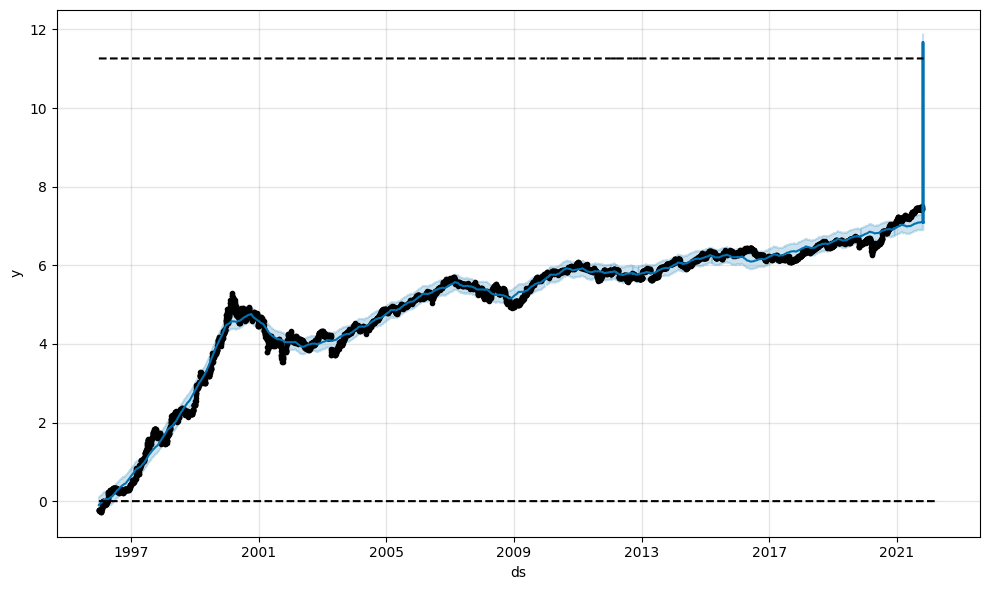

In [103]:
fig1 = model.plot(forecast)
plt.show()

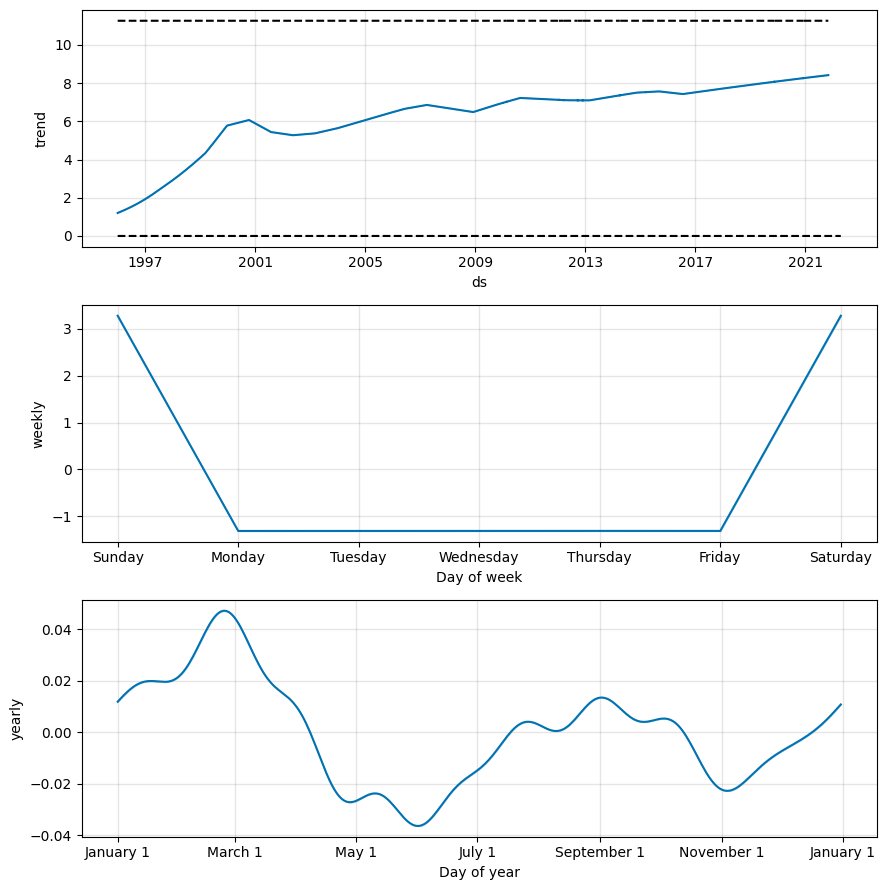

In [104]:
fig2 = model.plot_components(forecast)
plt.show()

Using all data for training

In [105]:
train = df_prophet.copy()

This ensures logistic growth and cancel nan

In [108]:
train['cap'] = df_prophet['cap'].max()
train['floor'] = df_prophet['floor'].min()


In [109]:
m = Prophet(
    growth='logistic',
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True
)
m.fit(train)


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1rnjs06s/ogs_2nah.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1rnjs06s/9pefelvt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39242', 'data', 'file=/tmp/tmp1rnjs06s/ogs_2nah.json', 'init=/tmp/tmp1rnjs06s/9pefelvt.json', 'output', 'file=/tmp/tmp1rnjs06s/prophet_modeli20rbfcb/prophet_model-20250819064753.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:47:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:48:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [117]:
future = m.make_future_dataframe(periods=365, freq='B')  # 365 business days
future['cap'] = df_prophet['cap'].max()
future['floor'] = df_prophet['floor'].min()


In [118]:
forecast = m.predict(future)

In [120]:
forecast['yhat_orig'] = np.exp(forecast['yhat'])
forecast['yhat_lower_orig'] = np.exp(forecast['yhat_lower'])
forecast['yhat_upper_orig'] = np.exp(forecast['yhat_upper'])


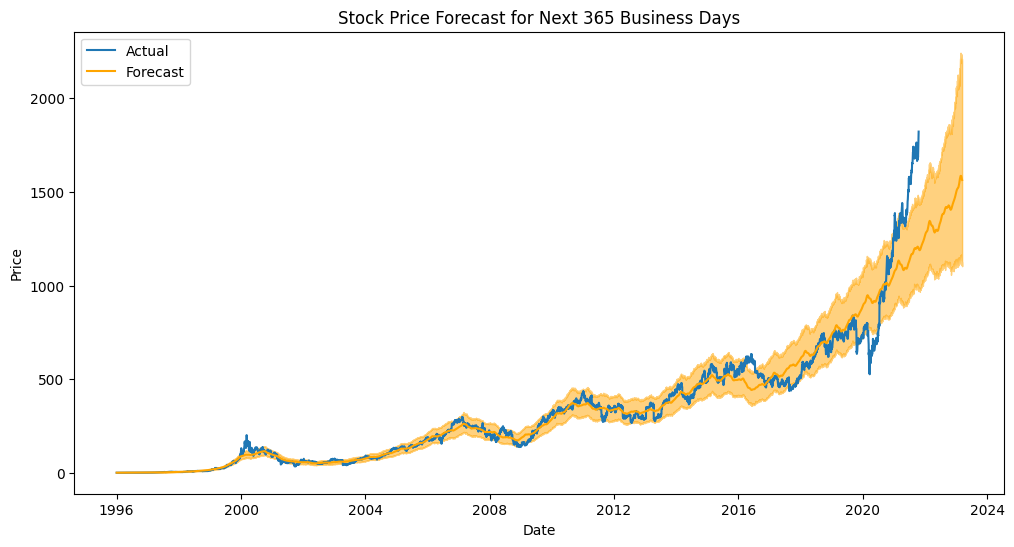

In [121]:
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Close'], label='Actual')
plt.plot(forecast['ds'], forecast['yhat_orig'], label='Forecast', color='orange')
plt.fill_between(forecast['ds'], forecast['yhat_lower_orig'], forecast['yhat_upper_orig'], color='orange', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price Forecast for Next 365 Business Days')
plt.legend()
plt.show()

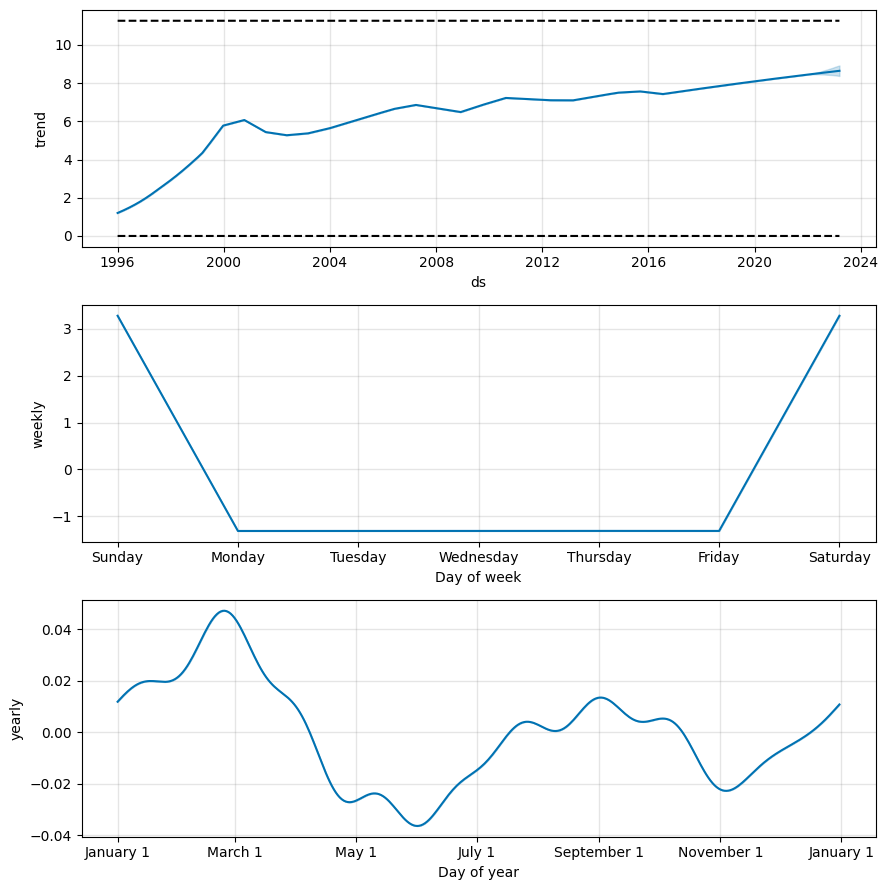

In [122]:
fig2 = m.plot_components(forecast)
plt.show()


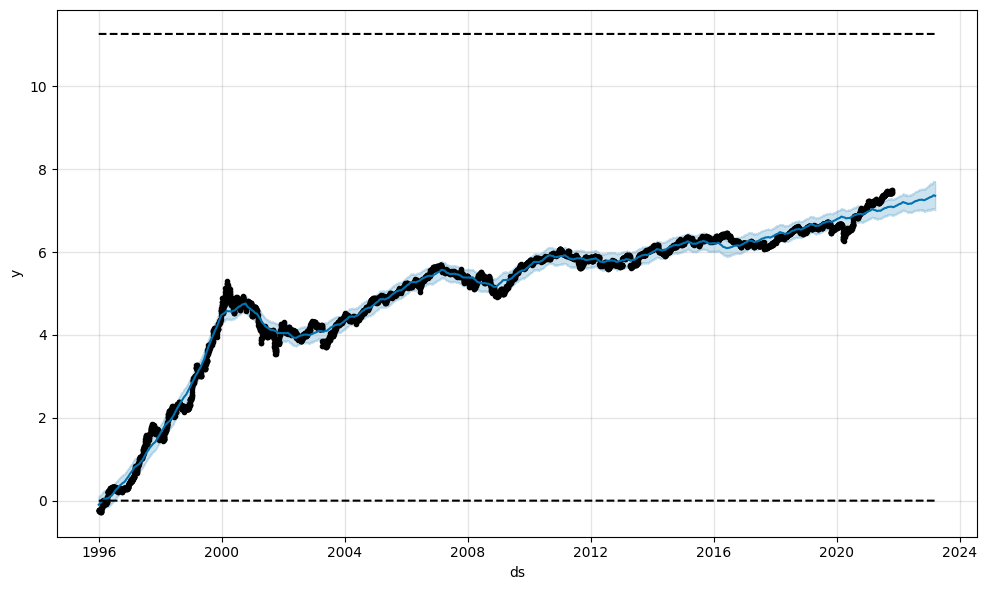

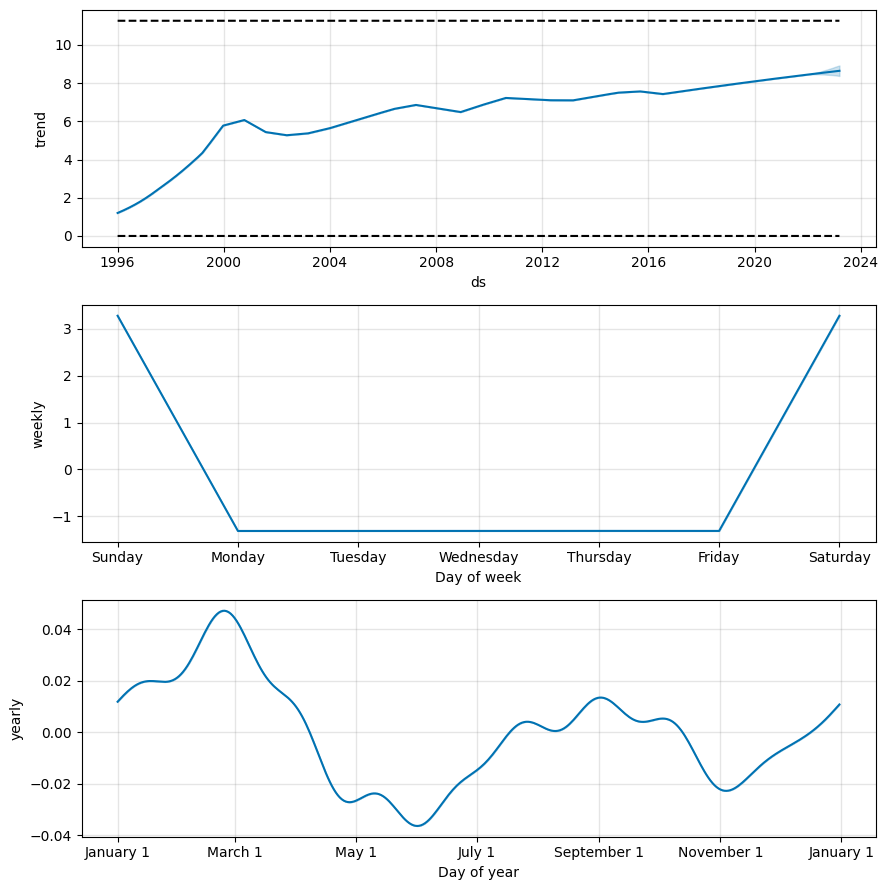

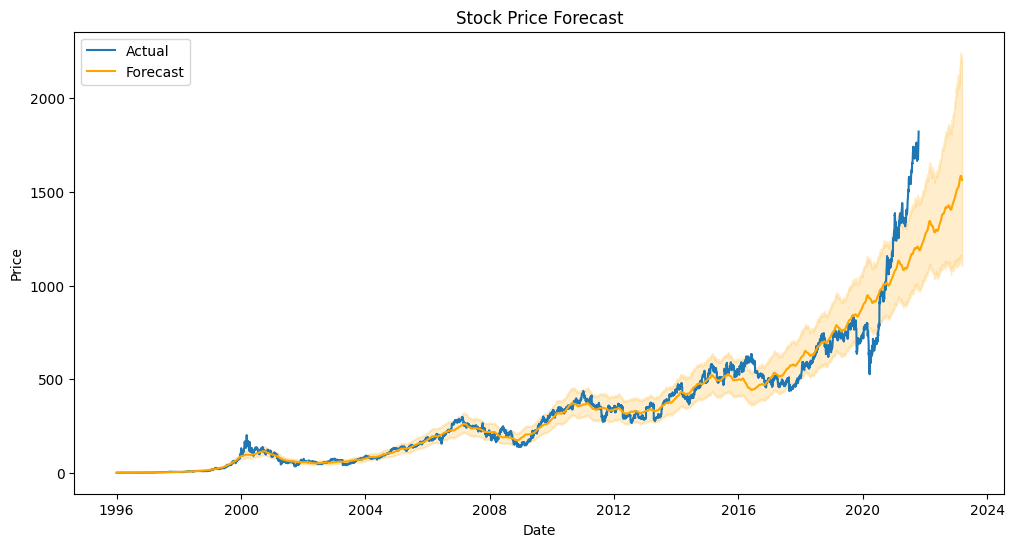

In [123]:
# Plot forecast in log scale
fig1 = m.plot(forecast)
plt.show()

# Plot trend, weekly, yearly components
fig2 = m.plot_components(forecast)
plt.show()

# Optional: Plot original price predictions
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Close'], label='Actual')
plt.plot(forecast['ds'], forecast['yhat_orig'], label='Forecast', color='orange')
plt.fill_between(forecast['ds'], forecast['yhat_lower_orig'], forecast['yhat_upper_orig'], color='orange', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price Forecast')
plt.legend()
plt.show()

In [124]:
forecast['ds'] = pd.to_datetime(forecast['ds'])


In [125]:
df['Date'] = pd.to_datetime(df['Date'])

In [126]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(10)

,ds,yhat,yhat_lower,yhat_upper
0,1996-01-01,-0.098244,-0.292453,0.100357
1,1996-01-02,-0.095387,-0.275518,0.094317
2,1996-01-03,-0.092644,-0.281503,0.092640
3,1996-01-04,-0.089688,-0.281332,0.106980
4,1996-01-05,-0.087720,-0.268761,0.106071
5,1996-01-08,-0.081586,-0.263645,0.115257
6,1996-01-09,-0.078955,-0.279003,0.124008
7,1996-01-10,-0.076483,-0.258407,0.101461
8,1996-01-11,-0.073841,-0.260693,0.103496
9,1996-01-12,-0.072226,-0.261321,0.113869


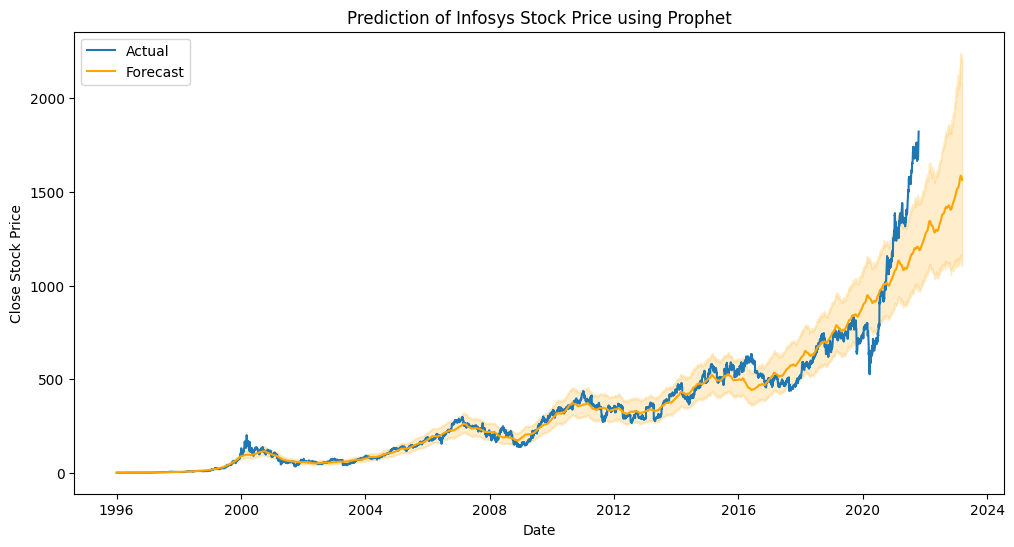

In [129]:
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Close'], label='Actual')
plt.plot(forecast['ds'], np.exp(forecast['yhat']), label='Forecast', color='orange')
plt.fill_between(
    forecast['ds'],
    np.exp(forecast['yhat_lower']),
    np.exp(forecast['yhat_upper']),
    color='orange', alpha=0.2
)
plt.xlabel("Date")
plt.ylabel("Close Stock Price")
plt.title("Prediction of Infosys Stock Price using Prophet")
plt.legend()
plt.show()

fig, ax1 = plt.subplots(figsize=(12,6))

---



In [132]:
# Assuming df_prophet is your full dataset
split_index = int(len(df_prophet) * 0.8)  # 80% training, 20% validation

train_p = df_prophet.iloc[:split_index].copy()
test_p = df_prophet.iloc[split_index:].copy()


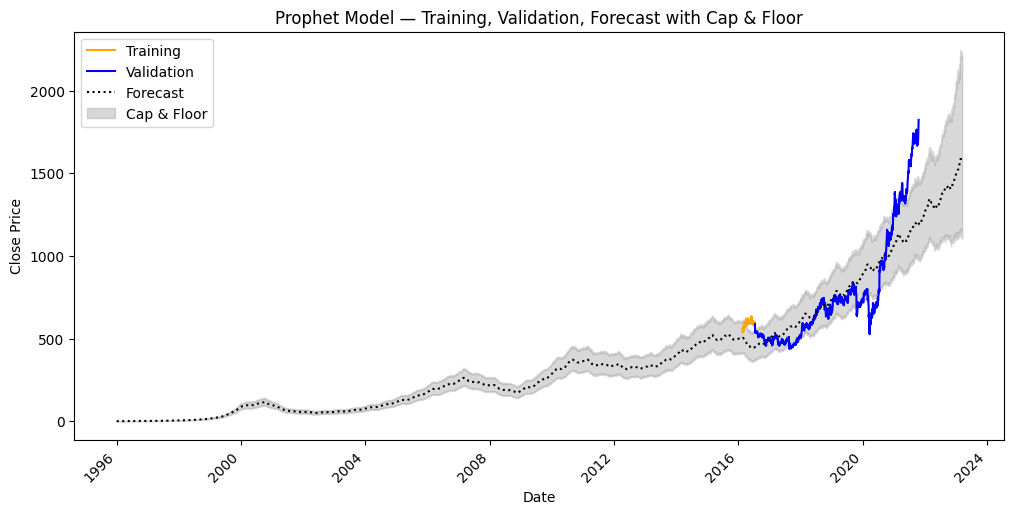

In [133]:
fig, ax1 = plt.subplots(figsize=(12,6))

# Plot last 100 points of training data
ax1.plot(train_p['ds'].iloc[-100:], np.exp(train_p['y'].iloc[-100:]), label='Training', color='orange')

# Plot validation/test data
ax1.plot(test_p['ds'], np.exp(test_p['y']), label='Validation', color='blue')

# Plot forecasted values
ax1.plot(forecast['ds'], np.exp(forecast['yhat']), color='black', linestyle=':', label='Forecast')

# Fill confidence interval
ax1.fill_between(forecast['ds'], np.exp(forecast['yhat_lower']), np.exp(forecast['yhat_upper']),
                 alpha=0.3, color='gray', label='Cap & Floor')

# Labels and title
ax1.set_title('Prophet Model — Training, Validation, Forecast with Cap & Floor')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price')
ax1.legend()
fig.autofmt_xdate(rotation=45)
plt.show()


In [134]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
6842,2023-03-01,7.368594,7.050489,7.708717
6843,2023-03-02,7.368543,7.061751,7.702051
6844,2023-03-03,7.367375,7.050729,7.703766
6845,2023-03-06,7.363600,7.045206,7.700988
6846,2023-03-07,7.362857,7.031953,7.711980
6847,2023-03-08,7.361968,7.041040,7.693707
6848,2023-03-09,7.361290,7.010710,7.710084
6849,2023-03-10,7.359652,7.030085,7.702142
6850,2023-03-13,7.355409,7.025650,7.700727
6851,2023-03-14,7.354806,7.006172,7.695580


Convert tail values to original scale

In [135]:
forecast['yhat_orig'] = np.exp(forecast['yhat'])
forecast['yhat_lower_orig'] = np.exp(forecast['yhat_lower'])
forecast['yhat_upper_orig'] = np.exp(forecast['yhat_upper'])

In [136]:
forecast[['ds', 'yhat_orig', 'yhat_lower_orig', 'yhat_upper_orig']].tail(10)

,ds,yhat_orig,yhat_lower_orig,yhat_upper_orig
6842,2023-03-01,1585.402909,1153.422077,2227.681621
6843,2023-03-02,1585.322910,1166.485540,2212.883047
6844,2023-03-03,1583.472178,1153.699505,2216.680719
6845,2023-03-06,1577.505757,1147.345716,2210.531377
6846,2023-03-07,1576.333738,1132.239737,2234.962316
6847,2023-03-08,1574.933351,1142.575261,2194.495154
6848,2023-03-09,1573.866239,1108.440721,2230.729569
6849,2023-03-10,1571.289390,1130.127161,2213.083672
6850,2023-03-13,1564.636408,1125.125361,2209.954488
6851,2023-03-14,1563.693835,1103.422204,2198.607883


plotting change points

In [137]:
from prophet.plot import plot_plotly, add_changepoints_to_plot

In [138]:
m = Prophet(growth='logistic', daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
m.fit(df_prophet)  # using all data

DEBUG:cmdstanpy:input tempfile: /tmp/tmp1rnjs06s/vo33zcak.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1rnjs06s/3nz62y9s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90242', 'data', 'file=/tmp/tmp1rnjs06s/vo33zcak.json', 'init=/tmp/tmp1rnjs06s/3nz62y9s.json', 'output', 'file=/tmp/tmp1rnjs06s/prophet_modelj5lo_kow/prophet_model-20250819072853.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:28:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:29:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [139]:
future = m.make_future_dataframe(periods=365, freq='B')
future['cap'] = df_prophet['cap'].max()
future['floor'] = df_prophet['floor'].min()


In [140]:
forecast = m.predict(future)

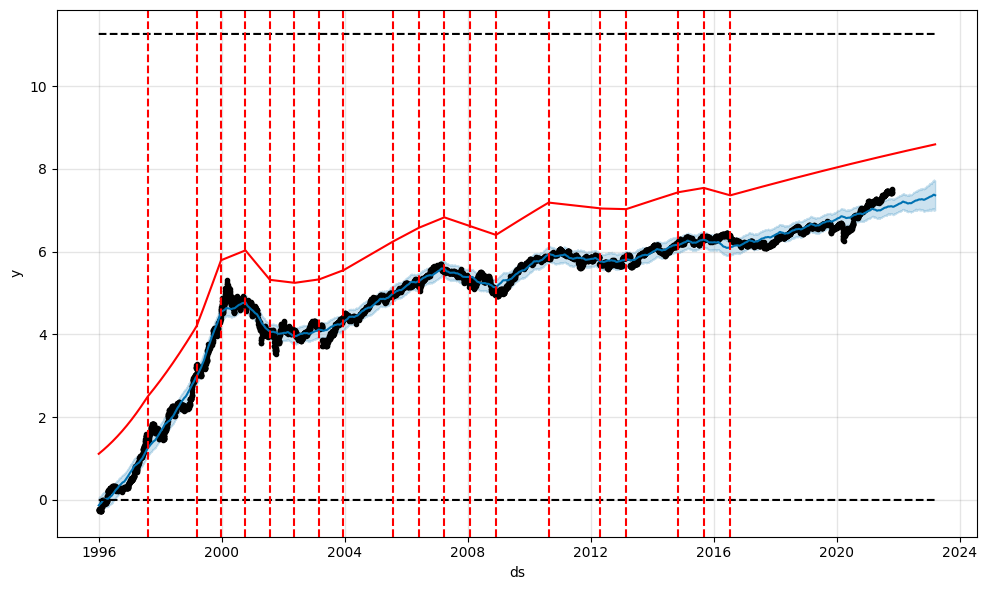

In [141]:
fig = m.plot(forecast)

# Add changepoints to the plot
a = add_changepoints_to_plot(fig.gca(), m, forecast)
plt.show()


In [142]:
m.changepoints.head(10)

,ds
208,1996-10-17
415,1997-08-04
623,1998-05-21
830,1999-03-08
1038,1999-12-23
1245,2000-10-09
1453,2001-07-26
1660,2002-05-13
1868,2003-02-27
2075,2003-12-15


In [143]:
m.changepoints.tail(10)

,ds
3320,2008-12-01
3528,2009-10-09
3735,2010-08-18
3943,2011-06-17
4150,2012-04-23
4358,2013-02-22
4565,2013-12-27
4773,2014-11-05
4980,2015-09-03
5188,2016-07-13


converting to csv

In [144]:
forecast['ds'] = pd.to_datetime(forecast['ds'])
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

In [145]:
forecast['yhat_orig'] = np.exp(forecast['yhat'])
forecast['yhat_lower_orig'] = np.exp(forecast['yhat_lower'])
forecast['yhat_upper_orig'] = np.exp(forecast['yhat_upper'])

In [146]:
split_index = int(len(df_prophet) * 0.8)
train_p = df_prophet.iloc[:split_index].copy()
test_p = df_prophet.iloc[split_index:].copy()


In [147]:
train_merged = train_p.merge(
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'yhat_orig', 'yhat_lower_orig', 'yhat_upper_orig']],
    on='ds', how='left'
)
train_merged['set'] = 'train'

In [148]:
test_merged = test_p.merge(
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'yhat_orig', 'yhat_lower_orig', 'yhat_upper_orig']],
    on='ds', how='left'
)
test_merged['set'] = 'test'


In [149]:
full_data = pd.concat([train_merged, test_merged], ignore_index=True)

In [150]:
full_data['changepoint'] = full_data['ds'].isin(m.changepoints).astype(int)

In [151]:
full_data.to_csv('prophet_forecast_with_changepoints.csv', index=False)

In [152]:
from google.colab import files

In [153]:
full_data.to_csv('prophet_forecast_with_changepoints.csv', index=False)

In [154]:
files.download('prophet_forecast_with_changepoints.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>